In this notebook, we would like to train the BCM learning rule realized through tf on MNIST dataset.

In [7]:
%reset -f
%reload_ext autoreload

# %load BCM_running.py

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import argparse
%matplotlib inline
from learning_plasticity import data_loader
from learning_plasticity import BCM_cl
from learning_plasticity import BCM_fully_connect_cl as BCM
# Reset tf.app.flags.FLAGS
tf.app.flags.FLAGS = tf.python.platform.flags._FlagValues()
tf.app.flags._global_parser = argparse.ArgumentParser()

from tensorflow.python.framework import ops
ops.reset_default_graph()


In [14]:
data = np.load('mnist_data.npy'')
labels = np.load('mnist_labels.npy')
data.shape

FileNotFoundError: [Errno 2] No such file or directory: '/Macintosh HD/Users/Shuang/GitHub/Dataset/MNIST/mnist_data.npy'

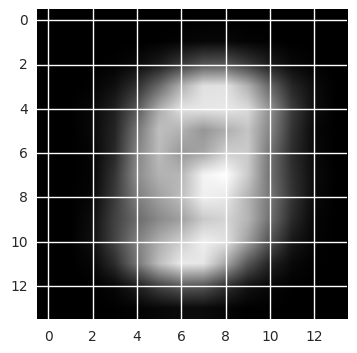

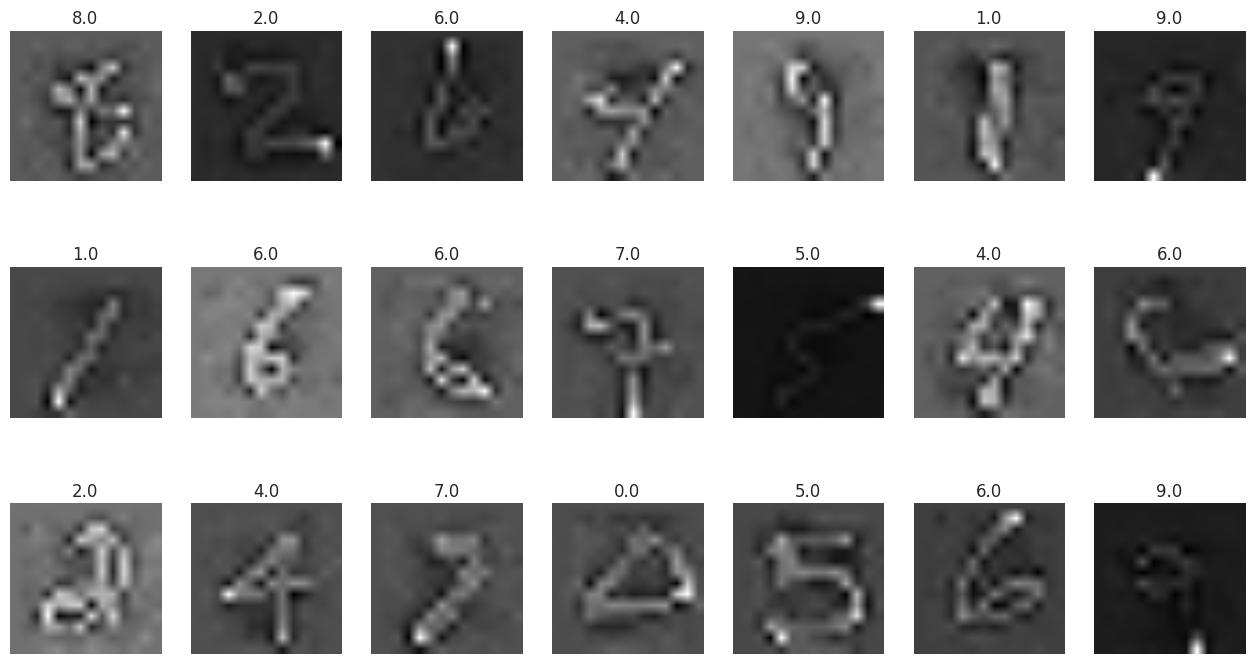

In [36]:
data = np.load('mnist_data.npy')
labels = np.load('mnist_labels.npy')

# Plot a gallery of images
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of images"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if len(titles)>0:
            plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

portion = 0.05
N = int(portion*data.shape[0])
shuffle_idx = np.random.permutation(data.shape[0])[:N]
data = data[shuffle_idx]
# shuffle_idx = np.random.permutation(data.shape[0])[:N]
labels = labels[shuffle_idx]

# demean
ave_total = data.mean(axis=0)
data -= ave_total 

# Perform zca whitening
ZCAMatrix = data_loader.zca_whitening_matrix(data.T)
data_wt = np.dot(data,ZCAMatrix)

# Perform normalization
data_wt

h = 14
w = 14
plt.imshow(ave_total.reshape(h,w),cmap=plt.cm.gray)
# Visualize the demeaned digits
plt_row = 3
plt_col = 7
data_view = []
titles_view = []
for i in range(plt_row*plt_col+1):
    data_view.append(data_wt[i,:].reshape(h,w))
    titles_view.append(labels[i])

plot_gallery(data_view, titles_view, h, w, n_row=plt_row, n_col=plt_col)

# To see what BCM learning rule is really doing, we will compare it with using PCA, ICA on MNIST

# See the downloaded MNIST data
#a = np.where(labels == 3,1,0)
#collections.Counter(a)y
# Take a small portion of the dyataset

In [37]:
data_wt.shape

(3500, 196)

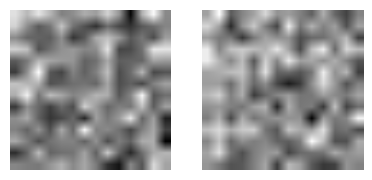

In [57]:
import pdb

def _shuffle(X):
    r_gen = np.random.RandomState()
    r = r_gen.permutation(X.shape[0])
    return X[r]

def dsigmoid(z):
    return tf.nn.sigmoid(z) * (1 - (tf.nn.sigmoid(z)))


n_output = 2
eta = 0.000001
decay = 0
p = 2
tau = 50
epoch = 50
seed = 0

sample_size = data_wt.shape[0]
dim_x = data_wt.shape[1]

# Give input place holder

input_value = tf.placeholder(tf.float64, [1, dim_x])
obj_input = tf.placeholder(tf.float64, [sample_size, dim_x])

# Varaible
r_gen = np.random.RandomState(seed)
w = tf.Variable(r_gen.randn(dim_x, n_output), dtype=tf.float64)
# w = tf.Variable(tf.zeros([dim_x, n_output])+0.2)
# w = tf.Variable(tf.random_normal([dim_x, n_output]))
threshold = tf.Variable(tf.zeros([1, n_output], dtype=tf.float64), dtype=tf.float64)

### Computation steps
# Compute output with ReLU
data_shuffle = tf.random_shuffle(tf.range(0,sample_size-1))
net_input = tf.matmul(input_value, w)
# output_value = tf.nn.relu(net_input)
output_value = tf.nn.sigmoid(net_input)

# Update weights with QBCM learning rule
out_thre_diff = output_value - threshold
# delta_w = eta * tf.matmul(input_value, tf.mul(output_value, out_thre_diff), transpose_a = True)- eta * decay * w
delta_w = eta * tf.matmul(input_value, tf.mul(tf.mul(output_value, out_thre_diff), dsigmoid(output_value)),transpose_a=True) - eta * decay * w
new_w = w + delta_w
update_w = tf.assign(w, new_w)

# Update threshold
h = tf.cast(tf.exp(-1/tau), tf.float64)
new_thres = threshold * h + tf.pow(output_value, p) * (1 - h)
update_thres = tf.assign(threshold, new_thres)

# Calculate QBCM objective function
obj_net_input = tf.matmul(obj_input, w)
obj_output = tf.nn.relu(obj_net_input)
obj1 = tf.reduce_mean(tf.pow(obj_output, 3))
obj2 = tf.reduce_mean(tf.pow(obj_output, 2))
obj = obj1/3 - tf.square(obj2)/4

# Train the model

init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

w_track = []
y_track = []
thres_track = []
output_track = []
for i in range(epoch):
    # _shuffle(data_shuffle)
    ind = sess.run(data_shuffle)
    data_train = data_wt[ind,:]
    for j in range(data_train.shape[0]):
#        print(data[j,:])
        w_track.append(sess.run(w))
        #sess.run(update_thres, feed_dict = {input_value: data[j,:].reshape(1,2)})
        #sess.run(obj, feed_dict = {obj_input: data})
        thres_track.append(sess.run(threshold))
        update_w_tmp, update_thres_tmp, output_tmp = sess.run([output_value, update_w, update_thres], feed_dict = {input_value: data_train[j,:].reshape(1,dim_x)})
        output_track.append(output_tmp)


# Plot the final weight
final_w = sess.run(w)
#plt.plot([0, data_w[0][0]], [0, data_w[0][1]], 'k')
#plt.plot([0, data_w[1][0]], [0, data_w[1][1]], 'k')
trained_w = np.vstack(w_track)
trained_thres = np.vstack(thres_track)

x = 14
y = 14
final_w_view = []
for i in range(final_w.shape[1]):
    final_w_view.append(final_w[:,i].reshape(x,y))

plot_gallery(final_w_view, titles = [], h = x, w = y, n_row=1, n_col=final_w.shape[1])

trained_thres = np.vstack(thres_track)
trained_output = np.vstack(output_track)


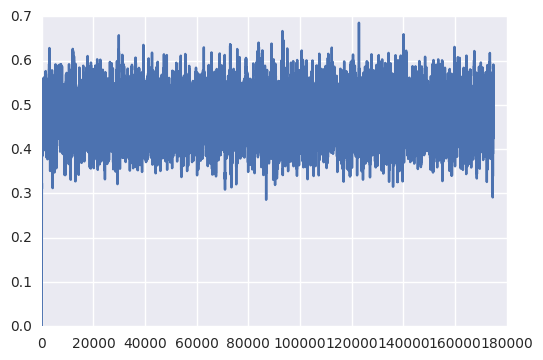

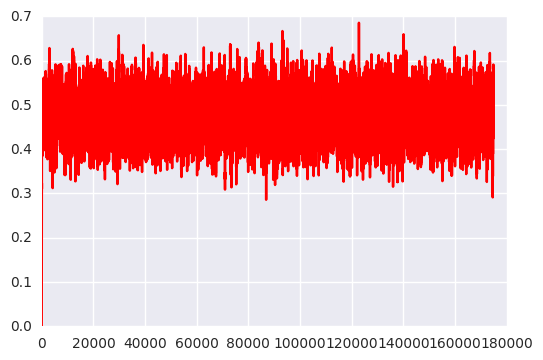

In [55]:
plt.figure()
plt.plot(trained_thres[:,0])
plt.figure()
plt.plot(trained_output[:,0],'r')

In [70]:
w = r_gen.randn(dim_x, n_output)
data_test = data[1,:]
net_input = np.dot(data_test[None,:], w)
net_input

array([[-669.58499573,  547.88197814]])

/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


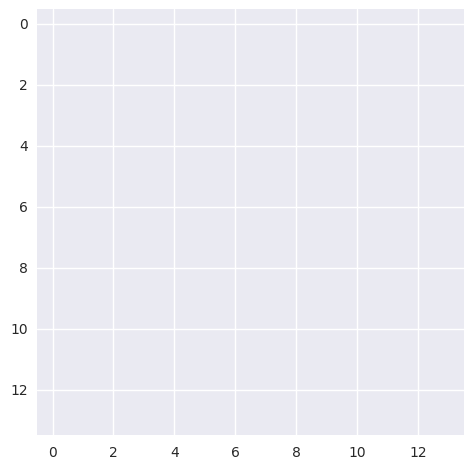

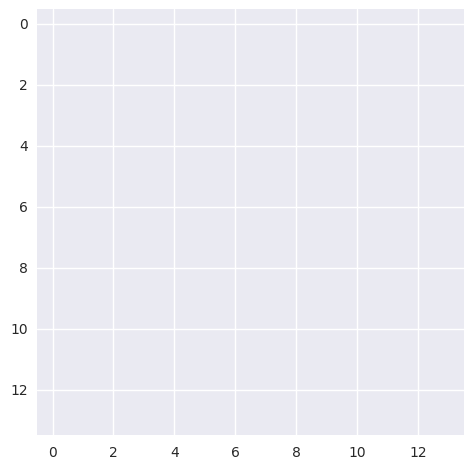

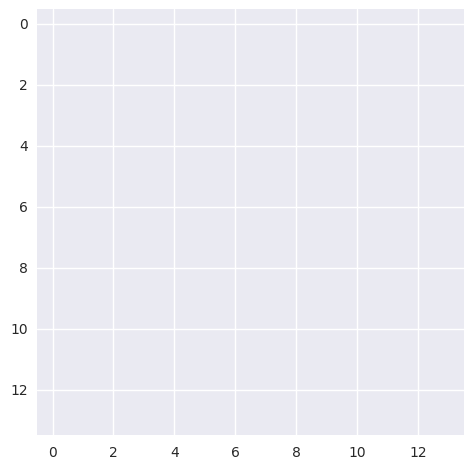

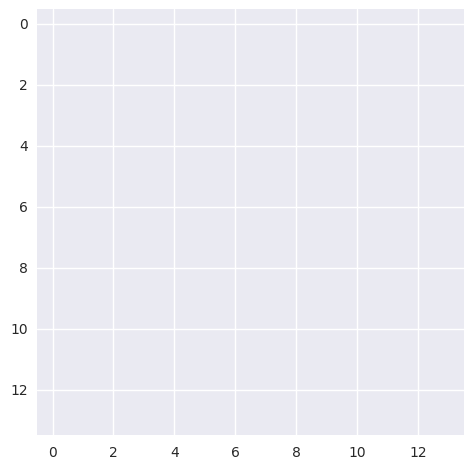

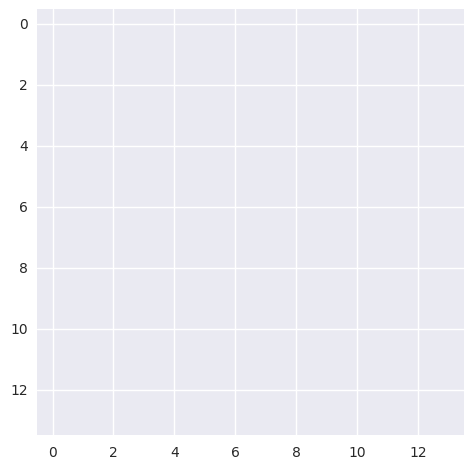

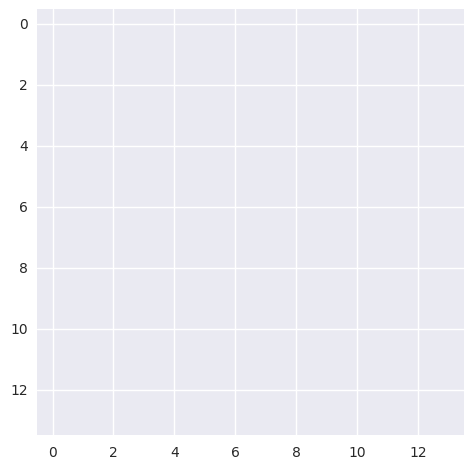

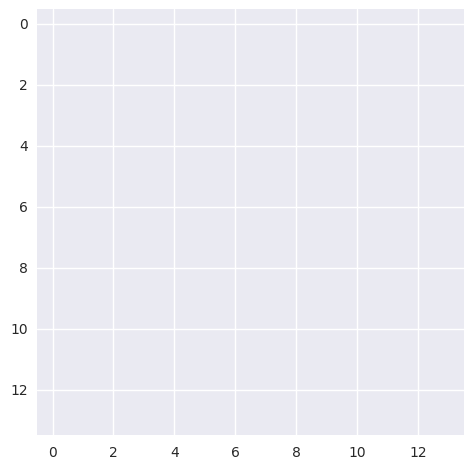

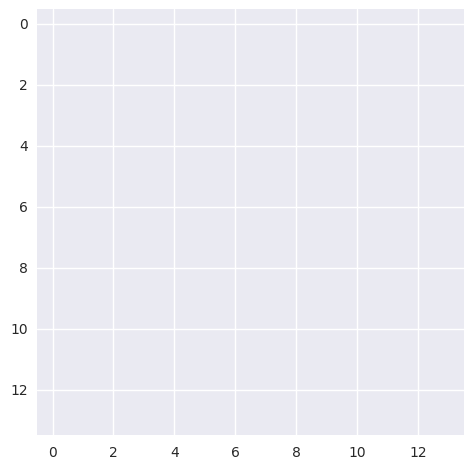

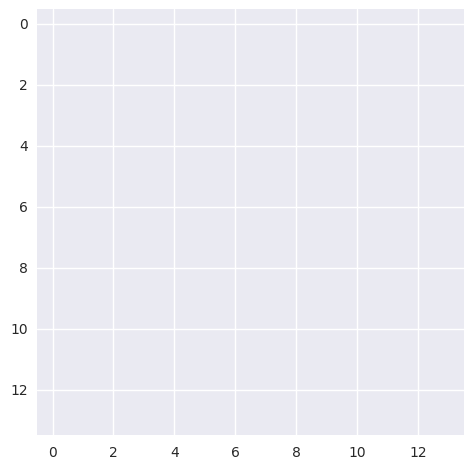

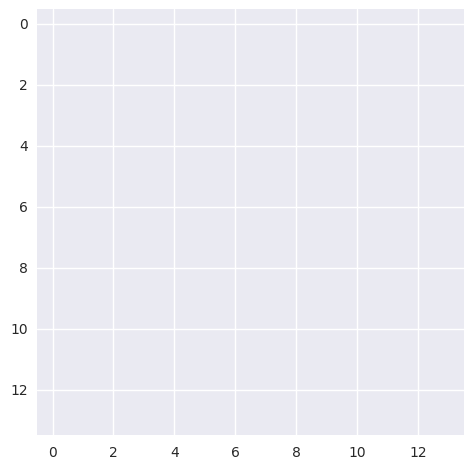

In [30]:
for i in range(60000, 60010):
    plt.figure()
    plt.imshow(w_track[i][:,1].reshape(14,14))

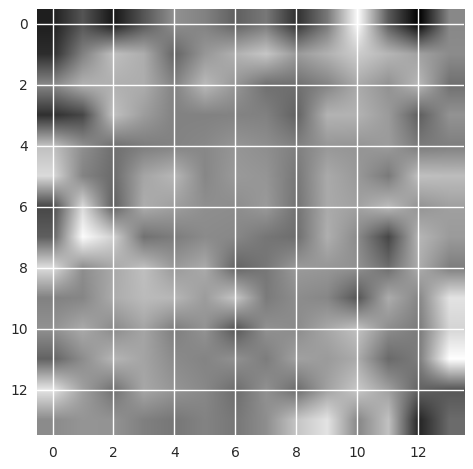

In [11]:
plt.imshow(w_track[18345][:,0].reshape(14,14))